# Titanic Survivors Prediction

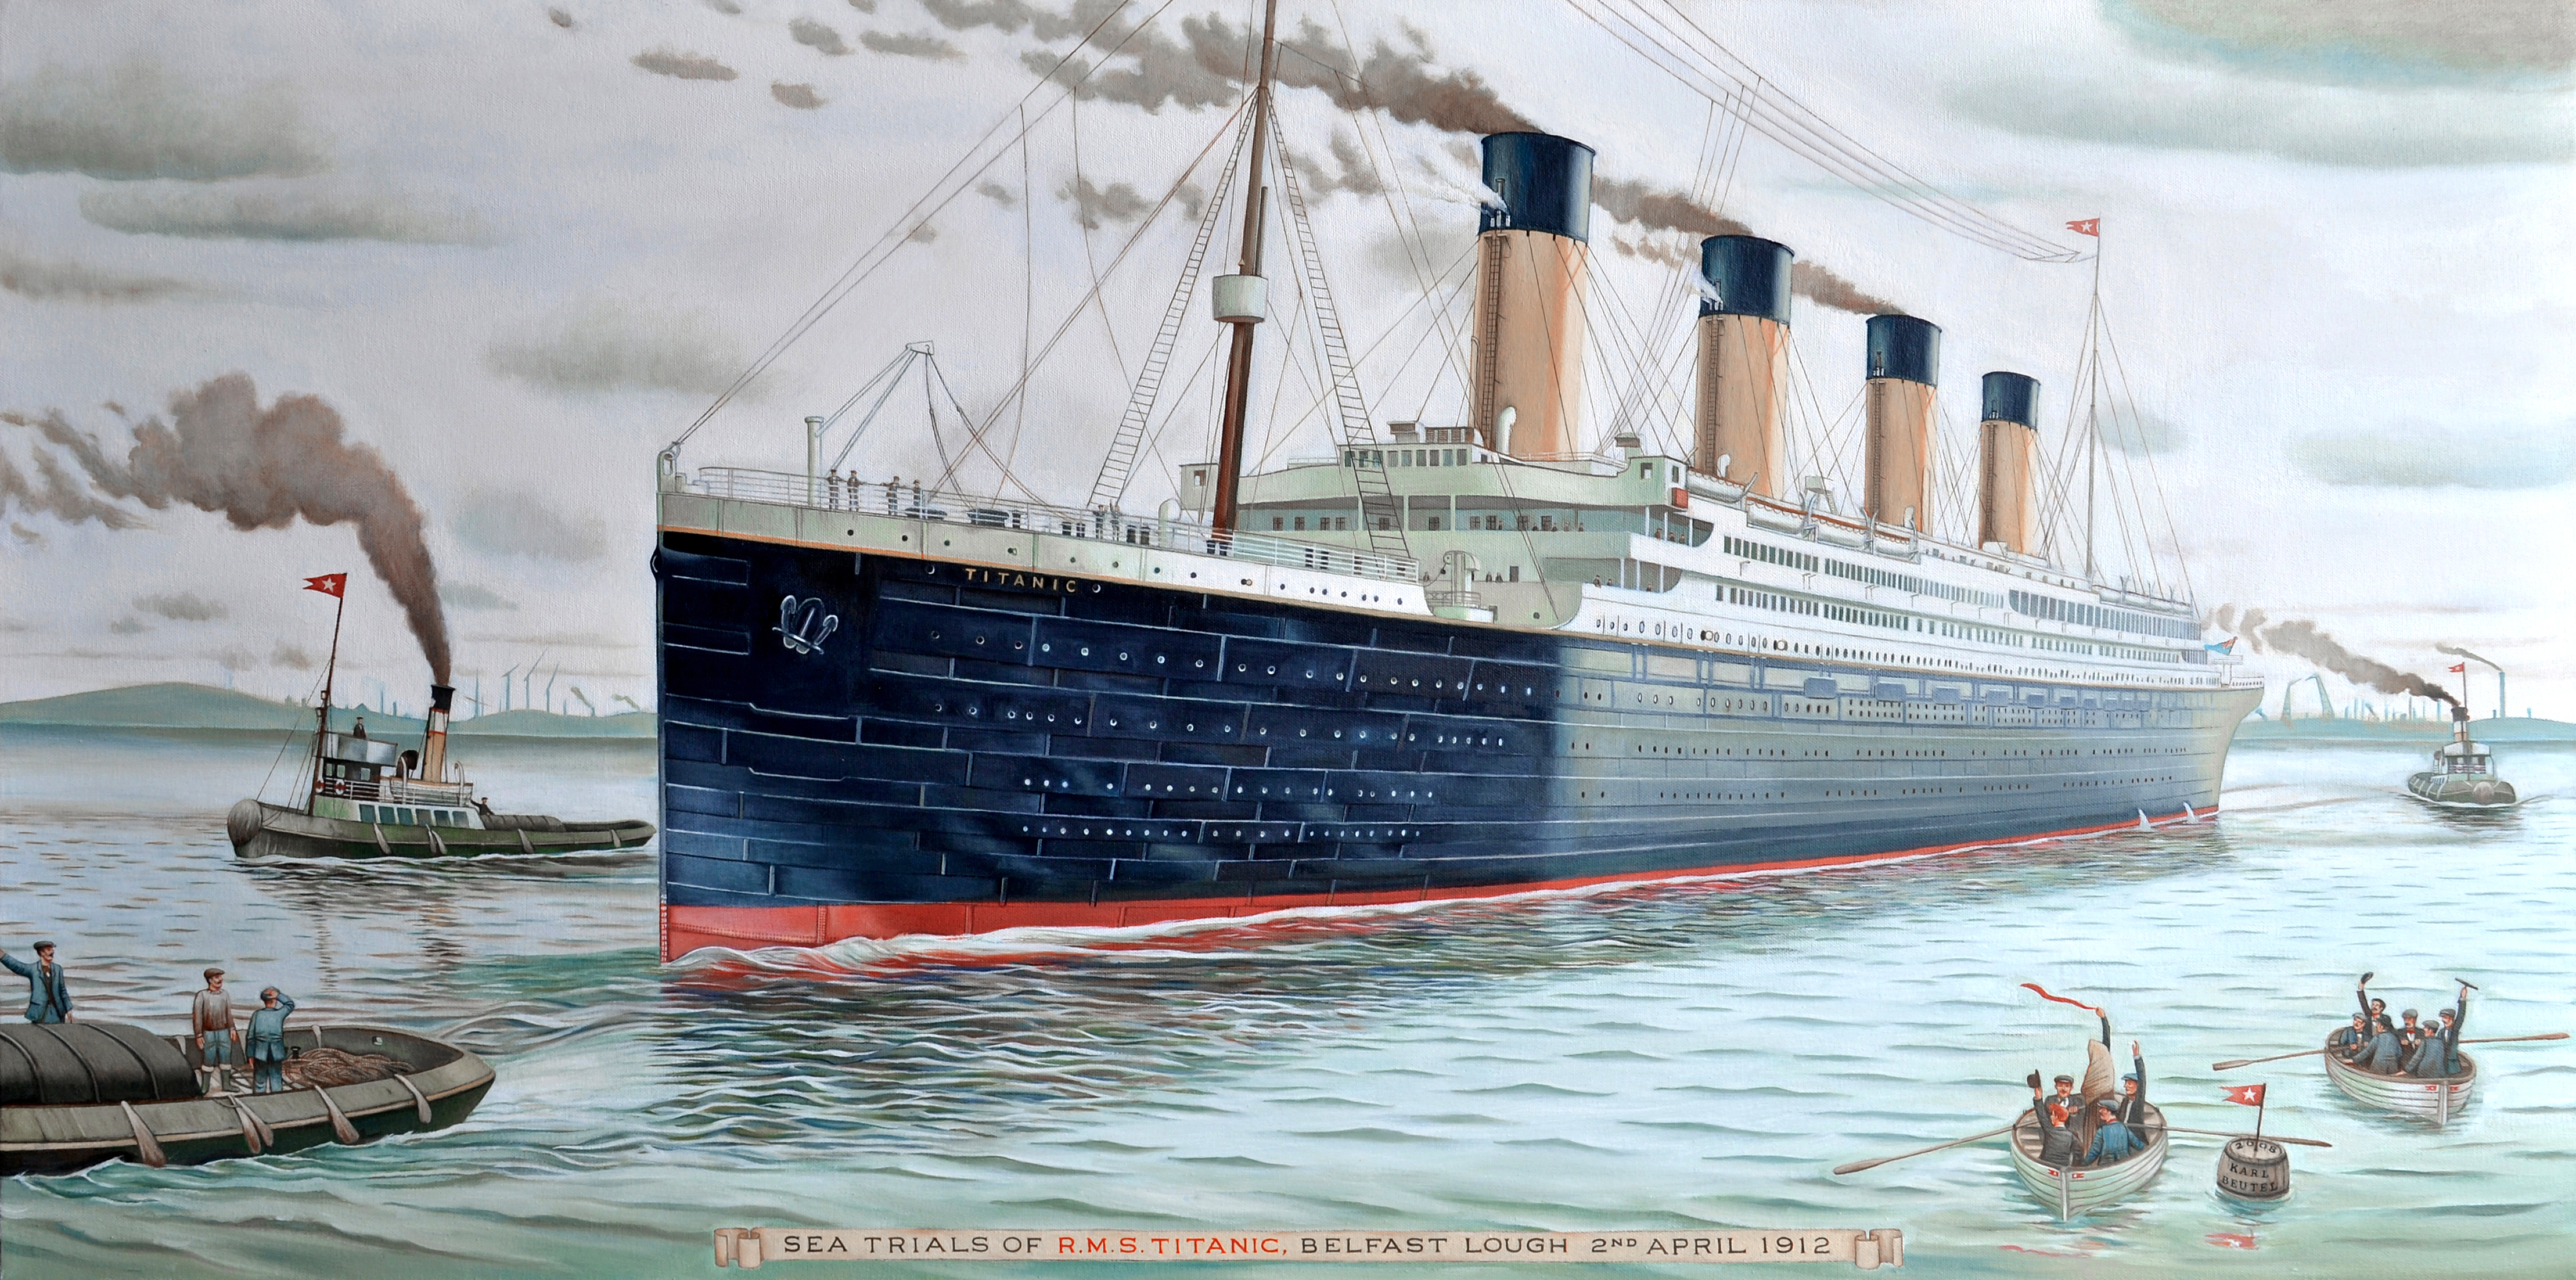

## Introduction

### AIM: Create a Machine Learning Model That Predicts Which Passengers Survived the Titanic

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

<h3><center>Data Dictionary</center></h3>

| Variable | Definition | Key |
| :-: | :- | :- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex |  | 
| Age | Age in years | 	  | 
| sibsp | # of siblings/spouses aboard |  | 
| parch | # of parents/children aboard |  | 
| ticket | Ticket number |  | 
| fare | Passenger fare |  | 
| cabin | Cabin number |  | 
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton | 

## 1. Import Data

### Import Libraries

In [30]:
import numpy as np
import pandas as pd

# Data Visualization
import seaborn as sns

# Data Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_selection import SelectPercentile, chi2

# Algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

# Evaluation Metrics
from sklearn.metrics import accuracy_score

# Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline

### Import Dataset

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Get a quick look at training set data
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## 2. Data Preprocessing

### 2.1 Understand Data

In [3]:
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
test.isnull().sum().to_frame()

0
PassengerId    0
Pclass         0
Name           0
Sex            0
Age           86
SibSp          0
Parch          0
Ticket         0
Fare           1
Cabin        327
Embarked       0

In [5]:
train['Age'].value_counts().to_frame()

Age
24.00   30
22.00   27
18.00   26
19.00   25
28.00   25
...    ...
36.50    1
55.50    1
0.92     1
23.50    1
74.00    1

[88 rows x 1 columns]

In [6]:
pd.DataFrame(train.isnull().mean().round(4).mul(100).sort_values(ascending=False), columns=['% of rows missing'])

% of rows missing
Cabin                    77.10
Age                      19.87
Embarked                  0.22
PassengerId               0.00
Survived                  0.00
Pclass                    0.00
Name                      0.00
Sex                       0.00
SibSp                     0.00
Parch                     0.00
Ticket                    0.00
Fare                      0.00

In [7]:
pd.DataFrame(test.isnull().mean().round(4).mul(100).sort_values(ascending=False), columns=['% of rows missing'])

% of rows missing
Cabin                    78.23
Age                      20.57
Fare                      0.24
PassengerId               0.00
Pclass                    0.00
Name                      0.00
Sex                       0.00
SibSp                     0.00
Parch                     0.00
Ticket                    0.00
Embarked                  0.00

### 2.2 Exploratory Data Analysis

https://www.stat.cmu.edu/~hseltman/309/Book/chapter4.pdf
https://www.geeksforgeeks.org/exploratory-data-analysis-eda-types-and-tools/
TYPES OF EXPLORATORY DATA ANALYSIS:
    - Univariate Non-graphical
    - Multivariate Non-graphical
    - Univariate graphical
    - Multivariate graphical

#### OBSERVATIONS

#### HYPOTHESIS

**Handle Missing Data**

Age: There are a total of 263 missing values for age in out training and testing dataset. We can replace the empty values with the average of the dataset, as the value is numeric

Embarked: Replacing missing Embarked values with the most frequently occuring value. Only 2 missing values, with string values.

Fare: There is only one missing value in Test set. We will replace it with the average Fare.

Cabin: We will drop the Cabin column for this iteration. How accurate are we without it? When we reintroduce it, how can we interpret this column better? Data enrichment seems to be necessary.

**Transform Data**

Sex, Embarked: Encode Categorical Variables

## 3. Build Models

Adopting the pipeline approach not only enhances the scalability of machine learning, but also improves the efficiency of model building.

In [8]:
X = train.drop('Survived', axis=1)
y = train['Survived']

### 3.1 Logistic Regression

In [22]:
# Identify numeric features and create a pipleline for cleaning
numeric_features = ["Age", "Fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), 
           ("scaler", StandardScaler())])

# Identify categorical features and create a pipleline for cleaning
categorical_features = ["Embarked", "Sex", "Pclass"]
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("selector", SelectPercentile(chi2, percentile=50))])

# Applying ColumnTransformer to numeric and catergorical features
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features),
                  ("cat", categorical_transformer, categorical_features)])

# Builing a Logistic Regression model after preprocessing the data
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression())])

# Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model the training set
clf.fit(X_train, y_train)

# Check the Z-score of model against test set
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.799


In [23]:
# Change median to mean in SimpleImputer

# Identify numeric features and create a pipleline for cleaning
numeric_features = ["Age", "Fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), 
           ("scaler", StandardScaler())])

# Identify categorical features and create a pipleline for cleaning
categorical_features = ["Embarked", "Sex", "Pclass"]
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("selector", SelectPercentile(chi2, percentile=50))])

# Applying ColumnTransformer to numeric and catergorical features
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features),
                  ("cat", categorical_transformer, categorical_features)])

# Builing a Logistic Regression model after preprocessing the data
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression())])

# Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model the training set
clf.fit(X_train, y_train)

# Check the Z-score of model against test set
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.799


In [24]:
# Change percentile from 50 to 80

# Identify numeric features and create a pipleline for cleaning
numeric_features = ["Age", "Fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), 
           ("scaler", StandardScaler())])

# Identify categorical features and create a pipleline for cleaning
categorical_features = ["Embarked", "Sex", "Pclass"]
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("selector", SelectPercentile(chi2, percentile=80))])

# Applying ColumnTransformer to numeric and catergorical features
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features),
                  ("cat", categorical_transformer, categorical_features)])

# Builing a Logistic Regression model after preprocessing the data
clf = Pipeline(
    steps=[("preprocessor", preprocessor), 
           ("classifier", LogisticRegression())])

# Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model the training set
clf.fit(X_train, y_train)

# Check the Z-score of model against test set
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.799


#### Graphs

### 3.2 Random Forest Classification

In [29]:
# Identify numeric features and create a pipleline for cleaning
numeric_features = ["Age", "Fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), 
           ("scaler", StandardScaler())])

# Identify categorical features and create a pipleline for cleaning
categorical_features = ["Embarked", "Sex", "Pclass"]
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("selector", SelectPercentile(chi2, percentile=50))])

# Applying ColumnTransformer to numeric and catergorical features
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features),
                  ("cat", categorical_transformer, categorical_features)])

# Creating a pipeline that first preprocesses the data, then scales the data, then fits the data to a RandomForsestClassifier
rfc = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', RandomForestClassifier(max_depth = 10,
                                     min_samples_leaf = 3,
                                     min_samples_split = 4,
                                     n_estimators = 200))])

# Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model the training set
rfc.fit(X_train, y_train)

# Check the Z-score of model against test set
print("model score: %.3f" % rfc.score(X_test, y_test))

model score: 0.855


### 3.3 K Nearest Neighbor

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  
Y_pred = knn.predict(X_test)  
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

In [32]:
# Identify numeric features and create a pipleline for cleaning
numeric_features = ["Age", "Fare"]
numeric_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="mean")), 
           ("scaler", StandardScaler())])

# Identify categorical features and create a pipleline for cleaning
categorical_features = ["Embarked", "Sex", "Pclass"]
categorical_transformer = Pipeline(
    steps=[("encoder", OneHotEncoder(handle_unknown="ignore")),
           ("selector", SelectPercentile(chi2, percentile=50))])

# Applying ColumnTransformer to numeric and catergorical features
preprocessor = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features),
                  ("cat", categorical_transformer, categorical_features)])

# Creating a pipeline that first preprocesses the data, then scales the data, then fits the data to a RandomForsestClassifier
rfc = Pipeline(steps = [
    ('preprocessor', preprocessor),
    ('model', KNeighborsClassifier(n_neighbors = 3))])

# Splitting the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Fit the model the training set
rfc.fit(X_train, y_train)

# Check the Z-score of model against test set
print("model score: %.3f" % rfc.score(X_test, y_test))

model score: 0.799


C:\Users\91953\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


Graphs for KNN

In [38]:
import sklearn; sklearn.show_versions()


System:
    python: 3.9.13 (main, Aug 25 2022, 23:51:50) [MSC v.1916 64 bit (AMD64)]
executable: C:\Users\91953\anaconda3\python.exe
   machine: Windows-10-10.0.19044-SP0

Python dependencies:
          pip: 22.2.2
   setuptools: 63.4.1
      sklearn: 1.0.2
        numpy: 1.21.5
        scipy: 1.9.1
       Cython: 0.29.32
       pandas: 1.4.4
   matplotlib: 3.5.2
       joblib: 1.1.0
threadpoolctl: 2.2.0

Built with OpenMP: True


C:\Users\91953\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [39]:
!pip install scikit-learn==

ERROR: Could not find a version that satisfies the requirement scikit-learn== (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.1, 1.2.2)
ERROR: No matching distribution found for scikit-learn==


In [40]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.pipeline import Pipeline
from sklearn.inspection import DecisionBoundaryDisplay


n_neighbors = 1

dataset = datasets.load_iris()
X, y = dataset.data, dataset.target

# we only take two features. We could avoid this ugly
# slicing by using a two-dim dataset
X = X[:, [0, 2]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.7, random_state=42
)

h = 0.05  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
cmap_bold = ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

names = ["KNN", "NCA, KNN"]

classifiers = [
    Pipeline(
        [
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=n_neighbors)),
        ]
    ),
    Pipeline(
        [
            ("scaler", StandardScaler()),
            ("nca", NeighborhoodComponentsAnalysis()),
            ("knn", KNeighborsClassifier(n_neighbors=n_neighbors)),
        ]
    ),
]

for name, clf in zip(names, classifiers):

    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    _, ax = plt.subplots()
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X,
        cmap=cmap_light,
        alpha=0.8,
        ax=ax,
        response_method="predict",
        plot_method="pcolormesh",
        shading="auto",
    )

    # Plot also the training and testing points
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor="k", s=20)
    plt.title("{} (k = {})".format(name, n_neighbors))
    plt.text(
        0.9,
        0.1,
        "{:.2f}".format(score),
        size=15,
        ha="center",
        va="center",
        transform=plt.gca().transAxes,
    )

plt.show()

ImportError: cannot import name 'DecisionBoundaryDisplay' from 'sklearn.inspection' (C:\Users\91953\anaconda3\lib\site-packages\sklearn\inspection\__init__.py)

## 4. Evaluate Models

## 5. Hyperparameter Tuning

## 6. Learning for Next Iteration